In [20]:
from os import listdir

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import zscore, pearsonr
from sklearn.decomposition import PCA

In [21]:
pd.options.mode.chained_assignment = None

# Hypothesis testing and mediation analyisis

## Loading preprocessed data tables

### self reports scales

In [22]:
emotion_scales_path = '/Users/giovanni/Documents/Datasets/LEMON/Behavioural_Data_MPILMBB_LEMON/Emotion_and_Personality_Test_Battery_LEMON/'
scale_names = [s.split('.')[0] for s in listdir(emotion_scales_path) if s.split('.')[1] == 'csv']
emotion_scales = {}

for sn in scale_names:
    scale_path = emotion_scales_path+sn+'.csv'
    s = pd.read_csv(scale_path)
    emotion_scales[sn]=s


In [23]:
scale = emotion_scales['TICS']
scale = scale.rename(columns={'Unnamed: 0':'sbj_id'})

scale_df = scale


scale = emotion_scales['PSQ']
scale = scale.replace(' ', np.nan)
scale = scale.dropna()
scale = scale.rename(columns={'Unnamed: 0':'sbj_id'})
scale = scale.astype({'PSQ_Worries': 'float', 'PSQ_Tension': 'float', 'PSQ_Joy': 'float', 'PSQ_Demands': 'float', 'PSQ_OverallScore': 'float'})

scale_df = scale_df.merge(scale, on='sbj_id', how='left')


scale = emotion_scales['STAI_G_X2']
scale = scale.rename(columns={'Unnamed: 0':'sbj_id'})

scale_df = scale_df.merge(scale, on='sbj_id', how='left').dropna()


z_question = zscore(scale_df[scale_df.columns[1:]].values, axis=0)
pca = PCA(n_components=3)
pca_question = pca.fit_transform(z_question)

scale_df['q_pca_1'] = pca_question[:,0]
scale_df['q_pca_2'] = pca_question[:,1]
scale_df['q_pca_3'] = pca_question[:,2]

scale_cols = scale_df.columns[1:]

### subject demographics and metadata

In [24]:
subject_meta_path = '/Users/giovanni/Documents/Datasets/LEMON/Behavioural_Data_MPILMBB_LEMON/META_File_IDs_Age_Gender_Education_Drug_Smoke_SKID_LEMON.csv'
subject_meta_df = pd.read_csv(subject_meta_path)
subject_meta_df = subject_meta_df.rename(columns={'Unnamed: 0':'sbj_id'})
subject_meta_df = subject_meta_df.rename(columns={'Gender_ 1=female_2=male':'gender'})
subject_meta_df['gender'] = subject_meta_df['gender'] -1 
subject_meta_df['Standard_Alcoholunits_Last_28days'] = subject_meta_df['Standard_Alcoholunits_Last_28days'].fillna('-1').apply(lambda x: x.replace(',','.')).astype(float)

for colname in subject_meta_df.columns:
    if (subject_meta_df.dtypes == 'object')[colname] == False:
        continue
    col = subject_meta_df[colname]
    code_dict = {k:v for v,k in enumerate(col.unique())}
    code_col = pd.DataFrame({colname+'_coded':[code_dict[c] for c in col]})
    subject_meta_df = subject_meta_df.join(code_col)

subject_meta_df['Age_num'] = subject_meta_df['Age'].apply(lambda x: np.mean(list(map(int, x.split('-')))))
subject_meta_df['Smoking_coded_bin'] = (subject_meta_df['Smoking_num_(Non-smoker=1, Occasional Smoker=2, Smoker=3)'] > 1).astype(int)

### heart features extracted from PPG

In [25]:
processed_data_path = '/Users/giovanni/Documents/Datasets/LEMON/processed/'
hrv_df = pd.read_json(processed_data_path+'LEMON_ppg_features.json')
hrv_df = hrv_df.rename(columns={'sd1/sd2':'sd1_sd2'})
hrv_df = hrv_df.groupby('sbj_id').mean().reset_index()

### brain activation and connectivty features (DMN)

In [26]:
fmri_df = pd.read_json(processed_data_path+'LEMON_fmri_rs_features_DMN_complete.json')[:]
fmri_df['DMN_amp_mean_PPC_LTJ'] = fmri_df[['DMN_amp_mean_PCC', 'DMN_amp_mean_LTJ']].mean(1)

### merging all tables in a single dataframe

In [27]:
hp_test_df = fmri_df.merge(hrv_df, on='sbj_id', how='left').dropna()

hp_test_df = hp_test_df.merge(subject_meta_df[['sbj_id',
                                               'gender', 
                                               'Age_num',
                                               'Smoking_coded_bin']], on='sbj_id', how='left').dropna()

hp_test_df = hp_test_df.merge(scale_df, on='sbj_id', how='left').dropna()
# selection_mask = (hp_test_df['sd1_sd2'] < .4) & (hp_test_df['STAI_Trait_Anxiety'] < 30)
selection_mask = (hp_test_df['sd1_sd2'] < .4) & (hp_test_df['STAI_Trait_Anxiety'] < 25)
print(hp_test_df[selection_mask==True].sbj_id)
hp_test_df = hp_test_df[selection_mask==False]

len(hp_test_df)


10    sub-032484
59    sub-032360
Name: sbj_id, dtype: object


104

## Hypothesis testing: individual associations

### STAI scores - HRV controlling for age, gender and smoking habits

In [36]:
col_selection = ['STAI_Trait_Anxiety', 'sd1_sd2', 'Age_num', 'gender', 'Smoking_coded_bin']

exp_df = hp_test_df[col_selection]

exp_df['sd1_sd2'] = np.log(exp_df['sd1_sd2'].values)
exp_df = exp_df.apply(zscore, axis=0)
predictors = exp_df.columns[1:].astype(str)
predicted = exp_df.columns[0]

model_formula = predicted+' ~ '+' + '.join(predictors) #+ '+ bpm:sd1_sd2'
results = smf.ols(model_formula, data=exp_df).fit()
print(results.summary())
print(pearsonr(exp_df['sd1_sd2'], results.resid))


                            OLS Regression Results                            
Dep. Variable:     STAI_Trait_Anxiety   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     2.374
Date:                Wed, 27 Apr 2022   Prob (F-statistic):             0.0573
Time:                        18:24:55   Log-Likelihood:                -142.81
No. Observations:                 104   AIC:                             295.6
Df Residuals:                      99   BIC:                             308.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          2.706e-16      0.09

In [477]:
# stargazer = Stargazer([results])
# stargazer.covariate_order(['Intercept', 'sd1_sd2', 'Age_num', 'gender', 'Smoking_coded_bin'])
# stargazer.rename_covariates({
#     # 'DMN_amp_mean_PPC_LTJ': 'D (DMN activation)',
#     'sd1_sd2': 'H (Heart rate variability)',
#     'Age_num': 'C (Age)',
#     'gender': 'C (Gender)',
#     'Smoking_coded_bin': 'C (Smoker)'
#     })
# stargazer.show_degrees_of_freedom(False)
# print(stargazer.render_latex())

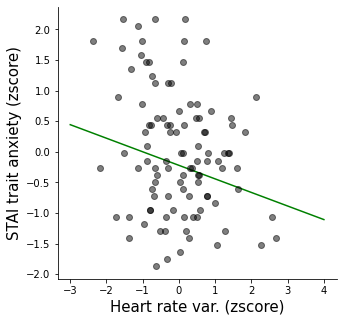

In [479]:
plt.figure(figsize=(5,5))
plt.plot(np.linspace(-3,4,10), results.params['Intercept'] + np.linspace(-2,5,10)* results.params['sd1_sd2'], 'g')
plt.plot(exp_df['sd1_sd2'], exp_df['STAI_Trait_Anxiety'], 'ko', alpha=.5)
plt.xlabel('Heart rate var. (zscore)', fontsize=15)
plt.ylabel('STAI trait anxiety (zscore)', fontsize=15)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)


### HRV - DMN activation controlling for age, gender and smoking habits

In [47]:
col_selection = ['sd1_sd2', 'DMN_amp_mean_PPC_LTJ', 'Age_num', 'gender', 'Smoking_coded_bin']

exp_df = hp_test_df[col_selection]
exp_df['sd1_sd2'] = np.log(exp_df['sd1_sd2'].values)
exp_df['DMN_amp_mean_PPC_LTJ'] = np.log(exp_df['DMN_amp_mean_PPC_LTJ'].values)
exp_df = exp_df.apply(zscore, axis=0)
predictors = exp_df.columns[1:].astype(str)
predicted = exp_df.columns[0]

model_formula = predicted+' ~ '+' + '.join(predictors) #+ '+ bpm:sd1_sd2'
results = smf.ols(model_formula, data=exp_df).fit()
print(results.summary())
print(pearsonr(exp_df['DMN_amp_mean_PPC_LTJ'], results.resid))

                            OLS Regression Results                            
Dep. Variable:                sd1_sd2   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     4.530
Date:                Wed, 27 Apr 2022   Prob (F-statistic):            0.00211
Time:                        18:29:57   Log-Likelihood:                -138.83
No. Observations:                 104   AIC:                             287.7
Df Residuals:                      99   BIC:                             300.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             -2.29e-16 

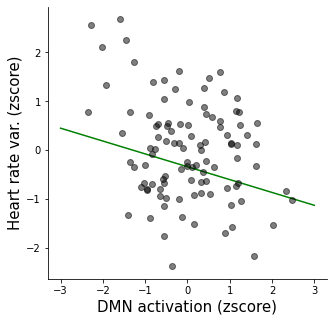

In [48]:
plt.figure(figsize=(5,5))
plt.plot(np.linspace(-3,3,10), results.params['Intercept'] + np.linspace(-2,5,10)* results.params['DMN_amp_mean_PPC_LTJ'], 'g')
plt.plot(exp_df['DMN_amp_mean_PPC_LTJ'], exp_df['sd1_sd2'], 'ko', alpha=.5)

plt.xlabel('DMN activation (zscore)', fontsize=15)
plt.ylabel('Heart rate var. (zscore)', fontsize=15)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

In [49]:
# stargazer = Stargazer([results])
# stargazer.covariate_order(['Intercept', 'DMN_amp_mean_PPC_LTJ', 'Age_num', 'gender', 'Smoking_coded_bin'])
# stargazer.rename_covariates({
#     'DMN_amp_mean_PPC_LTJ': 'D (DMN activation)',
#     # 'sd1_sd2': 'H (Heart rate variability)',
#     'Age_num': 'C (Age)',
#     'gender': 'C (Gender)',
#     'Smoking_coded_bin': 'C (Smoker)'
#     })
# stargazer.show_degrees_of_freedom(False)
# print(stargazer.render_latex())

### STAI score - DMN activation controlling for age, gender and smoking habits

In [51]:
col_selection = ['STAI_Trait_Anxiety', 'DMN_amp_mean_PPC_LTJ', 'Age_num', 'gender', 'Smoking_coded_bin']

exp_df = hp_test_df[col_selection]
exp_df['DMN_amp_mean_PPC_LTJ'] = np.log(exp_df['DMN_amp_mean_PPC_LTJ'].values)
exp_df = exp_df.apply(zscore, axis=0)
predictors = exp_df.columns[1:].astype(str)
predicted = exp_df.columns[0]

model_formula = predicted+' ~ '+' + '.join(predictors) #+ '+ bpm:sd1_sd2'
results = smf.ols(model_formula, data=exp_df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:     STAI_Trait_Anxiety   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     3.054
Date:                Wed, 27 Apr 2022   Prob (F-statistic):             0.0203
Time:                        18:31:11   Log-Likelihood:                -141.52
No. Observations:                 104   AIC:                             293.0
Df Residuals:                      99   BIC:                             306.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             2.706e-16 

In [447]:
# stargazer = Stargazer([results])
# stargazer.covariate_order(['Intercept', 'DMN_amp_mean_PPC_LTJ', 'Age_num', 'gender', 'Smoking_coded_bin'])
# stargazer.rename_covariates({
#     'DMN_amp_mean_PPC_LTJ': 'D (DMN activation)',
#     # 'sd1_sd2': 'H (Heart rate variability)',
#     'Age_num': 'C (Age)',
#     'gender': 'C (Gender)',
#     'Smoking_coded_bin': 'C (Smoker)'
#     })
# stargazer.show_degrees_of_freedom(False)
# print(stargazer.render_latex())

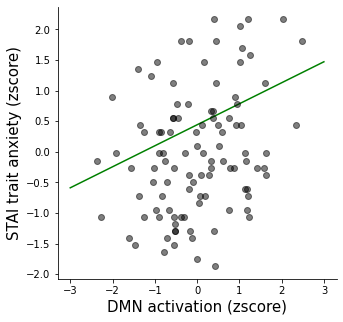

In [52]:
plt.figure(figsize=(5,5))
plt.plot(np.linspace(-3,3,10), results.params['Intercept'] + np.linspace(-2,5,10)* results.params['DMN_amp_mean_PPC_LTJ'], 'g')
plt.plot(exp_df['DMN_amp_mean_PPC_LTJ'], exp_df['STAI_Trait_Anxiety'], 'ko', alpha=.5)
plt.xlabel('DMN activation (zscore)', fontsize=15)
plt.ylabel('STAI trait anxiety (zscore)', fontsize=15)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

## Mediation analysis

In [57]:
import statsmodels.api as sm
from statsmodels.stats.mediation import Mediation


col_selection = ['STAI_Trait_Anxiety', 'sd1_sd2', 'DMN_amp_mean_PPC_LTJ', 'Age_num', 'gender', 'Smoking_coded_bin']
exp_df = hp_test_df[col_selection]
exp_df = exp_df.apply(zscore, axis=0)


outcome_model = sm.OLS.from_formula("STAI_Trait_Anxiety ~ DMN_amp_mean_PPC_LTJ + sd1_sd2 + Age_num + gender + Smoking_coded_bin", exp_df)
mediator_model = sm.OLS.from_formula("sd1_sd2 ~ DMN_amp_mean_PPC_LTJ + Age_num + gender + Smoking_coded_bin", exp_df)
med = Mediation(outcome_model, mediator_model, "DMN_amp_mean_PPC_LTJ", "sd1_sd2").fit(n_rep=1000)
print(med.summary())

                          Estimate  Lower CI bound  Upper CI bound  P-value
ACME (control)            0.033318       -0.020392        0.119275    0.312
ACME (treated)            0.033318       -0.020392        0.119275    0.312
ADE (control)             0.266922        0.054909        0.492192    0.016
ADE (treated)             0.266922        0.054909        0.492192    0.016
Total effect              0.300240        0.088263        0.521046    0.010
Prop. mediated (control)  0.089568       -0.105997        0.481856    0.314
Prop. mediated (treated)  0.089568       -0.105997        0.481856    0.314
ACME (average)            0.033318       -0.020392        0.119275    0.312
ADE (average)             0.266922        0.054909        0.492192    0.016
Prop. mediated (average)  0.089568       -0.105997        0.481856    0.314


In [2]:
from os import listdir

In [5]:
path = '/Users/giovanni/Documents/Datasets/LEMON/physio'
listdir(path)

['sub-032412',
 'sub-032396.tar.gz',
 'sub-032334.tar',
 'sub-032320.tar',
 'sub-032446.tar',
 'sub-032415',
 'sub-032388.tar.gz',
 'sub-032423',
 'sub-032424',
 'sub-032470',
 'sub-032484',
 'sub-032483',
 'sub-032477',
 'sub-032441',
 'sub-032479',
 'sub-032321.tar',
 'sub-032446',
 'sub-032447.tar',
 'sub-032453.tar',
 'sub-032492.tar.gz',
 'sub-032335.tar',
 'sub-032309.tar',
 'sub-032445.tar.gz',
 'sub-032323.tar',
 'sub-032337.tar',
 'sub-032425',
 'sub-032451.tar',
 'sub-032438.tar.gz',
 'sub-032422',
 'sub-032526.tar.gz',
 'sub-032426.tar.gz',
 'sub-032377.tar.gz',
 'sub-032457.tar.gz',
 'sub-032413',
 'sub-032434.tar.gz',
 'sub-032461.tar.gz',
 'sub-032330.tar.gz',
 'sub-032478',
 'sub-032447',
 'sub-032402.tar.gz',
 'sub-032502.tar.gz',
 'sub-032440',
 'sub-032449',
 'sub-032473.tar.gz',
 'sub-032476',
 'sub-032482',
 'sub-032336.tar',
 'sub-032510.tar.gz',
 'sub-032485',
 'sub-032444.tar',
 'sub-032322.tar',
 'sub-032410.tar.gz',
 'sub-032478.tar',
 'sub-032471',
 'sub-03232